# Order pattern for Black Echelle in LHD

## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter
import os
import numpy as np
import plotly.graph_objects as go
from lmfit.models import GaussianModel
from ipywidgets import interact,widgets
from IPython.display import display, HTML

%matplotlib inline

In [2]:
# Don't know how to import locally, so I just use %run
%run ../src/echelle_spectra/tools/echelle.py

In [3]:
files_cmos_2024 = {
    "orders": "pattern_CMOS_20240305.txt",
    "wavelength": "Th_wavelength_CMOS_20240305.txt",
    "sphr": "sphere_CMOS_20240305.sif",
    "bkgr": "sphere_CMOS_20240305_bkg.sif",
    "integral": "integrating_sphere.txt",
}
bpth = '../src/echelle_spectra/resources/calibration_files'

In [4]:
cb = Calibrations(folder=bpth, filenames=files_cmos_2024)
cb.start()
cb.sphr.calculate_order_spectra()
cb.bkgr.calculate_order_spectra()
sphr = cb.sphr
sphrbg = cb.bkgr

In [5]:
bpth_calib_images = '../../20240305_calib'

In [6]:
#th = EchelleImage(os.path.join(bpth,'ThAr-0.3s-x3_20240305.sif'),clbr=cb)
#th = EchelleImage(os.path.join(bpth_calib_images,'ThAr-10s-x3.sif'),clbr=cb)
#th = EchelleImage(os.path.join(bpth_calib_images,'Ne-2s-x3-dim-lines.sif'),clbr=cb)
#th = EchelleImage(os.path.join(bpth_calib_images,'Ne-0.15s-x3-bright-lines.sif'),clbr=cb)
#th = EchelleImage(os.path.join(bpth_calib_images,'Hg-0.1s-x3-brigh-lines.sif'),clbr=cb)
#th = EchelleImage(os.path.join(bpth_calib_images,'Hg-1.0s-x3-dimm-lines.sif'),clbr=cb)
#th = EchelleImage(os.path.join(bpth_calib_images,'H2-1s-x3-Balmer.sif'),clbr=cb)
th = EchelleImage(os.path.join(bpth_calib_images,'H2-5min-Fulcher-try2.sif'),clbr=cb)


th.calculate_order_spectra()
subtract = [i.min() for i in th.order_spectra[0]]

In [7]:
x = np.arange(cb.DIMW)
#orders = [3,4,5,6,7,8,9]
#orders = range(th.order_spectra.shape[1])
#orders = [10,11,12]
orders = [1,2,3]
#orders = range(28)

pg_data = []
for i,nord in enumerate(orders):
    pg_data.append(
        go.Scatter(
            x = x+1935*i - 18*i**2,
            y=(th.order_spectra[0,nord]-subtract[nord])/sphr.order_spectra[0,nord]+3e-3*i,
            name = nord,
        )
    )

fig = go.Figure(data=pg_data)
fig.update_layout(template='plotly_white')
fig.show()

In [8]:
def fit_line(nord,x0,d,lamp_image,sphr,cb):
    """ Fit line from an order to get center in pixels"""
    x = np.arange(cb.DIMW)
    y = (lamp_image.order_spectra[0,nord]-subtract[nord])/sphr.order_spectra[0,nord]

    y = y[x0-d:x0+d]
    y = y - y.min()
    x = x[x0-d:x0+d]
    plt.plot(x,y,'o',label=f'order={nord}')

    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.guess(y, x=x)
    mod = gauss1 
    out = mod.fit(y, pars, x=x)

    xlong = np.linspace(x0-d,x0+d,200)
    plt.plot(xlong,mod.eval(out.params,x=xlong),label='fit')
    center = out.params['g1_center'].value
    plt.axvline(center,c='k',ls='--')
    #txt = f'center = {center:.4f} wavelength = {wvs[nord][i]}'
    txt = f'center = {center:.4f}'
    ax = plt.gca()
    ax.text(0.2,1.1,txt,transform=ax.transAxes)
    plt.legend()
    print(txt)
    return f'{center:.4f}'

def output_to_clipboard(output):
    """ Put the result into clipboard when the cell is done """
    # Convert output to string if it's not already
    output_str = str(output)
    
    # Display the output as HTML
    display(HTML(f"<div id='output'>{output_str}</div>"))

    # Copy the output to the clipboard using JavaScript
    js_code = """
    function copyToClipboard() {
      const outputElement = document.getElementById('output');
      const range = document.createRange();
      range.selectNode(outputElement);
      window.getSelection().removeAllRanges();
      window.getSelection().addRange(range);
      document.execCommand('copy');
      window.getSelection().removeAllRanges();
    }

    copyToClipboard();
    """
    display(HTML("<script>" + js_code + "</script>"))

# Orders

The plotly figure is an interactive order plot to find the lines.
How to do the calibration:

1. Open old table if available
2. Go select an order, look for a line from a table
3. Zoom in
4. Plugin center of the peak into the fitting cell
5. If fit is fine, copy the center value (in pixels) into the table
6. Go through all the lamps and exposures to cover all the lines
7. Check the calibration in the third cell.

In [9]:
orders = range(th.order_spectra.shape[1])

x = np.arange(cb.DIMW)
initial_nord = 3
initial_y = (th.order_spectra[0, initial_nord] - subtract[initial_nord]) / sphr.order_spectra[0, initial_nord]
fig = go.FigureWidget(data=[go.Scatter(x=x, y=initial_y, name=str(initial_nord))])
fig.update_layout(template='plotly_white')

def plotfunc(nord):
    y = (th.order_spectra[0, nord] - subtract[nord]) / sphr.order_spectra[0, nord]
    fig.data[0].y = y  # Update the y-data of the existing trace
    fig.data[0].name = str(nord)  # Update the name of the trace

interact(plotfunc, nord=widgets.Dropdown(options=orders, value=initial_nord, description='order'))

display(fig)

interactive(children=(Dropdown(description='order', index=3, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

FigureWidget({
    'data': [{'name': '3',
              'type': 'scatter',
              'uid': '6322658d-c8d3-46e3-99f8-20dc19be7af3',
              'x': array([   0,    1,    2, ..., 2557, 2558, 2559]),
              'y': array([0.00676256, 0.00973402, 0.01371515, ..., 0.01276861, 0.01508889,
                          0.02102304], dtype=float32)}],
    'layout': {'template': '...'}
})

center = 453.4658


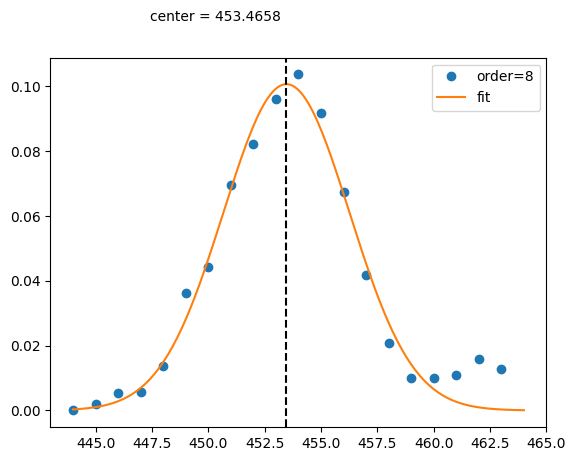

In [10]:
nord = 8
x0 = 454
center = fit_line(nord,x0,10,th,sphr,cb)
output_to_clipboard(center)

# Check Wavelenght calibration

In [11]:
import pandas as pd

In [12]:
bpth = '../src/echelle_spectra/resources/calibration_files/'
fpth = bpth+'Th_wavelength_CMOS_20240305.txt'
#wcal = np.loadtxt(fpth, skiprows=2, usecols=(0, 1, 2, 3, 4))
names=['ord','from','to','center','wavelength','band']
wcal = pd.read_csv(fpth,sep='\\t',comment='#',names=names)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_31440\1761796266.py:5: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



Text(0, 0.5, 'wavelength, nm')

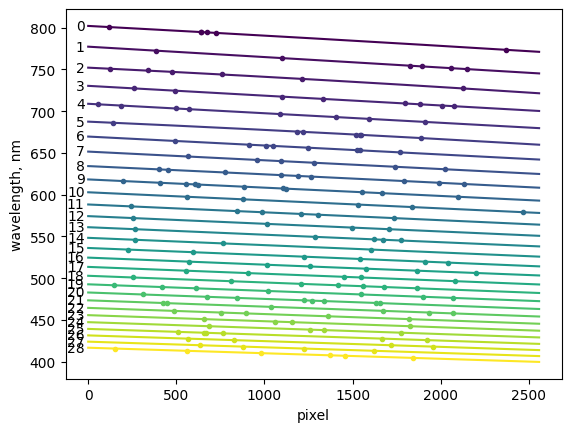

In [13]:
bpth = '../src/echelle_spectra/resources/calibration_files/'
fpth = bpth+'Th_wavelength_CMOS_20240305.txt'
#wcal = np.loadtxt(fpth, skiprows=2, usecols=(0, 1, 2, 3, 4))
names=['ord','from','to','center','wavelength','band']
wcal = pd.read_csv(fpth,sep='\t',comment='#',names=names)

ab = lambda x: 1 if x < 3 else 2

#orders = [3]
orders = range(29)
clrs = plt.cm.viridis(np.linspace(0, 1, len(orders)))
wfits = {}
ax = plt.gca()
for j,nord in enumerate(orders):
    p = wcal[wcal['ord']==nord]['center']
    w = wcal[wcal['ord']==nord]['wavelength']
    f = np.poly1d(np.polyfit(p,w,ab(len(p))))
    wfits[nord] = f
    x = np.arange(cb.DIMW)
    plt.plot(x,f(x),c=clrs[j],label=nord)
    plt.plot(p,w,'.',c=clrs[j])
    ax.text(-20,f(0),nord,ha='right',va='center')
#plt.legend(loc=1,bbox_to_anchor=[1.15,1])
plt.xlabel('pixel')
plt.ylabel('wavelength, nm')

In [14]:
bpth = '../src/echelle_spectra/resources/calibration_files/'
fpth = bpth + 'Th_wavelength_CMOS_20240305.txt'
names = ['ord', 'from', 'to', 'center', 'wavelength', 'band']
wcal = pd.read_csv(fpth, sep='\t', comment='#', names=names)

ab = lambda x: 1 if x < 3 else 2

#orders = range(29)
#orders = range(8)
orders = [8,9]
clrs = [
    f'rgb({rgb[0]}, {rgb[1]}, {rgb[2]})' 
    for rgb in np.linspace((0, 0, 255), (255, 0, 255), len(orders))
        ] 
wfits = {}
fig = go.Figure()

for j, nord in enumerate(orders):
    p = wcal[wcal['ord'] == nord]['center']
    w = wcal[wcal['ord'] == nord]['wavelength']
    f = np.poly1d(np.polyfit(p, w, ab(len(p))))
    wfits[nord] = f
    x = np.arange(cb.DIMW)
    
    fig.add_trace(go.Scatter(x=x, y=f(x), mode='lines', name=str(nord), line=dict(color=clrs[j])))
    fig.add_trace(go.Scatter(x=p, y=w, mode='markers', marker=dict(color=clrs[j]), showlegend=False))
    #fig.add_annotation(x=-0, y=f(0), text=str(nord), align='right', valign='middle')

    if j % 2 == 0:  # Alternate between left and right annotations
        x_coord = -20
        align = 'right'
        arrow_direction = 0    
    else:
        x_coord = cb.DIMW
        align = 'right'
        arrow_direction = 0        
    
    fig.add_annotation(
        x=x_coord, y=f(x_coord), text=str(nord),
        valign='middle',ay=arrow_direction,
        xanchor='left'
        )


fig.update_layout(
    xaxis_title='pixel',
    yaxis_title='wavelength, nm',
    template='plotly_white',
    height=800,  # Set height to 600 pixels
    width=800    # Set width to 800 pixels
)

# Show the figure
fig.show()

# Plont current calibration

In [15]:
th.calibrate()

In [16]:
orders = range(th.order_spectra.shape[1])

initial_nord = 0
initial_y = th.order_spectra[0][initial_nord]
initial_x = th.clbr.order_wavel[initial_nord]
fig = go.FigureWidget(data=[go.Scatter(x=x, y=initial_y, name=str(initial_nord))])
fig.update_layout(template='plotly_white')

def plotfunc(nord):
    y=th.order_spectra[0][nord]
    x = th.clbr.order_wavel[nord]
    fig.data[0].y = y  
    fig.data[0].x = x
    fig.data[0].name = str(nord)

interact(plotfunc, nord=widgets.Dropdown(options=orders, value=initial_nord, description='order'))

display(fig)

interactive(children=(Dropdown(description='order', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

FigureWidget({
    'data': [{'name': '0',
              'type': 'scatter',
              'uid': '6d030537-9340-4090-9e59-a9af547f26b6',
              'x': array([802.01985949, 802.00859305, 801.99732594, ..., 771.0399396 ,
                          771.02697392, 771.01400758]),
              'y': array([16153., 13525., 13496., ..., 15631., 15606., 15342.])}],
    'layout': {'template': '...'}
})